In [1]:
import os
import sys
import warnings; warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import scipy.stats as ss

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

from sklearn.metrics import (roc_auc_score, roc_curve,
                             confusion_matrix, classification_report)

In [2]:
# добавляем в sys.path директорию со скриптами
src_dir = os.path.join(os.getcwd(), '..', 'ocp')
sys.path.append(src_dir)

In [3]:
# загружаем необходимые скрипты
from data.loading import load_data, load_obj
from data.saving import save_obj
from data.splitting import train_holdout_split

%load_ext autoreload
%autoreload

SEED = 26

In [4]:
train, test, numerical, categorical = load_data('../data/processed')

In [5]:
(_, _, _, 
 _, _, y_holdout,
 _) = train_holdout_split(train, random_state=SEED)

In [6]:
models = load_obj('../data/models_dictionary/models_final.pkl')

# Подбор порога классификации с учетом экономических потерь

Построим ROC, Precision-Recall, Cumulative Gain, Lift кривые и по ним оценим эффективность построенной модели.

In [7]:
alpha = models['stacking']['alpha']
stacking_probs = models['stacking']['holdout_probs']

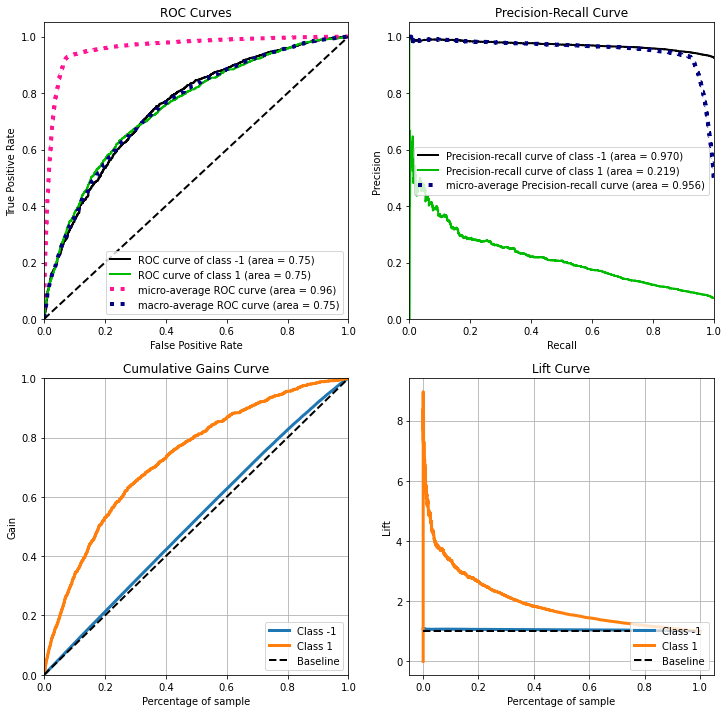

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

skplt.metrics.plot_roc_curve(y_holdout,
                             stacking_probs,
                             ax=axes[0][0]);

skplt.metrics.plot_precision_recall_curve(y_holdout,
                                          stacking_probs,
                                          ax=axes[0][1]);

skplt.metrics.plot_cumulative_gain(y_holdout,
                                   stacking_probs,
                                   ax=axes[1][0]);

skplt.metrics.plot_lift_curve(y_holdout,
                              stacking_probs,
                              ax=axes[1][1]);

Низкие значения ROC-AUC и PR-AUC для объектов класса оттока говорят о том, что модель не позволяет очень качественно
выделить данный класс из общего числа пользователей. Однако, опираясь на Cumulative Gain Curve и Lift Curve, можно
уверенно сказать, что построенная модель выделяет класс оттока намного лучше, чем при случайном выборе.

Посмотрим на качество классификации с порогом по умолчанию, равным 0.5.

In [9]:
# превращаем вероятности в предсказания меток классов
vmap = np.vectorize(lambda x: 1 if x else -1)
stacking_preds = vmap(stacking_probs[:, 1].flatten() > 0.5)

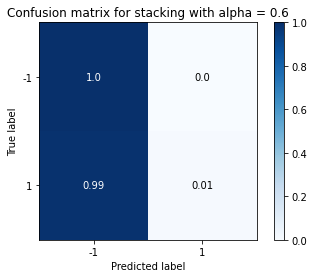

In [31]:
skplt.metrics.plot_confusion_matrix(y_holdout,
                                    stacking_preds,
                                    title=f'Confusion matrix for stacking with alpha = {alpha}', 
                                    normalize=True);

In [11]:
# посмотрим также на отчет по классификации
print(f'Classification report for stacking with alpha = {alpha}:' + '\n')
print(classification_report(y_holdout, stacking_preds, digits=3), '\n')

Classification report for stacking with alpha = 0.6:

              precision    recall  f1-score   support

          -1      0.926     1.000     0.961     12218
           1      0.583     0.007     0.014       982

    accuracy                          0.926     13200
   macro avg      0.755     0.503     0.488     13200
weighted avg      0.901     0.926     0.891     13200
 



Из анализа матрицы ошибок и классификационного отчета следует, что модель при пороге равном 0.5 правильно идентифицирует
 только 0.7% от всех пользователей, принадлежащих к классу оттока. Попробуем подобрать более низкий порог с учетом
 экономических затрат и потерь.

Оценим годовые убытки от проведенной кампании по удержанию клиентов в зависимости от выбираемого порога классификации.
Т.к. я не обладаю информацией о необходимых для моделирования экономических показателях компании Orange, которая
предоставила оригинальные данные, то для расчетов я воспользовался данными об экономических показателях
российского телеком-оператора Beeline, взятыми из
[этого источника](https://www.comnews.ru/content/208488/2020-08-07/2020-w32/bilayn-pokazal-vysokuyu-zavisimost-tradicionnoy-biznes-modeli).

Условия проведения кампании по удержанию также являются вымышленными.
В реальной практике такое оценивание потребует консультации со специалистами компании-заказчика, для которой
данная модель будет разрабатываться.

Теперь представим, что проводится следующая кампания по удержанию клиентов. Клиентам, отнесенным моделью к классу оттока,
мы предлагаем 20% скидку на услуги связи в течение года. Об этом мы уведомляем их путем смс-рассылки
(будем считать, что стоимость одного смс-сообщения равна 1 рублю). Средний месячный доход с одного клиента для нашей
модельной задачи равен 332 рублям. Будем считать, что процент удержания клиентов равен 70%, а также что
клиенты, которые ошибочно были отнесены к классу оттока, в 100% случаев будут соглашаться на предлагаемые им условия.

In [25]:
# получим сетку порогов с помощью roc_curve
_, _, thrs = roc_curve(y_holdout, stacking_probs[:, 1].flatten())

# для каждого из порогов будем считать количество TP, FP и FN
tp_grid, fp_grid, fn_grid = (np.zeros(thrs.shape),
                             np.zeros(thrs.shape),
                             np.zeros(thrs.shape))

for i, thr in enumerate(thrs):
    # конвертируем вероятности в оценки классов по порогу
    preds_by_thr = vmap(stacking_probs[:, 1].flatten() > thr)

    # c помощью матрицы ошибок получаем TP, FP и FN
    _, fp, fn, tp = confusion_matrix(y_holdout, preds_by_thr).ravel()

    # записываем их
    tp_grid[i] = tp
    fp_grid[i] = fp
    fn_grid[i] = fn

In [26]:
# далее для каждого из порогов проведем
# расчет суммарных потерь

# средний годовой доход с одного клиента
ayrpu = 332*12

# стоимость удержания одного клиента
discount = 0.2
churn_cost = ayrpu * discount + 1

# процент удержания после взаимодействия
prob_return = 0.7

# считаем потери
losses = (
    # правильно распознаны, принимают предложение
    tp_grid * prob_return * (-churn_cost)
    # правильно распознаны, не принимают предложение
    + tp_grid * (1-prob_return) * (-ayrpu)
    # не распознаны моделью вовсе
    + fn_grid * (-ayrpu)
    # неправильно распознаны, принимают предложение
    + fp_grid * (-churn_cost)
)

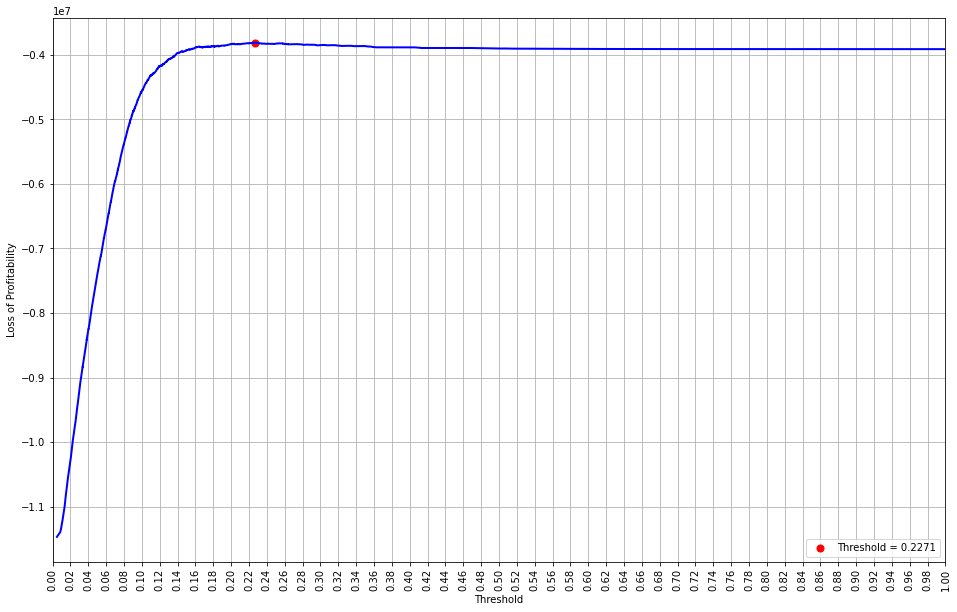

In [27]:
# выберем порог классификации, при котором
# достигаются минимальные потери
thrs_best = thrs[losses == max(losses)][0]

# отрисуем полученные данные
fig = plt.figure(figsize=(16, 10))
plt.plot(thrs, losses, color='b', lw=2)
plt.scatter([thrs_best], [max(losses)], color='r', s=50, label='Threshold = {:.4f}'.format(thrs_best))
plt.xlim([0, 1])
plt.xticks(ticks=np.arange(0, 1.01, 0.02), rotation=90)
plt.xlabel('Threshold')
plt.ylabel('Loss of Profitability')
plt.legend(loc="lower right")
plt.grid()
plt.show()

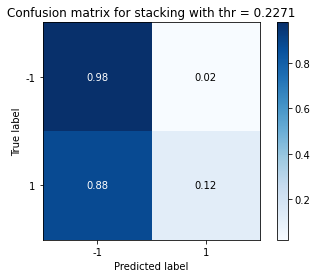

In [30]:
# превращаем вероятности в предсказания меток классов по выбранному порогу
stacking_preds_23 = vmap(stacking_probs[:, 1].flatten() > thrs_best)

skplt.metrics.plot_confusion_matrix(y_holdout,
                                    stacking_preds_23,
                                    title=f'Confusion matrix for stacking with thr = {thrs_best:.4f}', 
                                    normalize=True);

In [29]:
# посмотрим также на отчет по классификации
print(f'Classification report for stacking stacking with thr = {thrs_best:.4f}:' + '\n')
print(classification_report(y_holdout, stacking_preds_23, digits=3), '\n')

Classification report for stacking stacking with thr = 0.2271:

              precision    recall  f1-score   support

          -1      0.933     0.983     0.957     12218
           1      0.366     0.120     0.181       982

    accuracy                          0.919     13200
   macro avg      0.650     0.552     0.569     13200
weighted avg      0.891     0.919     0.900     13200
 



Оценим экономическую эффект модели, вычислив процент, на который уменьшаться убытки при её внедрении.

In [ ]:
# потери до внедрения модели
# (будем считать, что до этого момента 
# никакого прогнозирования оттока не совершалось)
losses_before = losses[0]

# минимальные потери после внедрения
losses_after = losses.max()

# считаем процент, на который уменьшаются убытки
profit = (losses_before - losses_after) * 100 / losses_before
print(f'Profit = {profit:.1f}%')

Классификация по оптимальному, с точки зрения экономических потерь, порогу позволяет выявить 12% клиентов класса оттока при этом всего 2% лояльных клиентов получать предложение о скидке по ошибке.
С учетом коэффициента удержания, равного 0.7, итоговая модель при внедрении позволит уменьшить годовой отток клиентов на 8.4%, а также уменьшить убытки на 2.6% относительно полного отсутствия прогнозирования. 

In [43]:
Классификация по оптимальному, с точки зрения экономических потерь, порогу позволяет выявить 12% клиентов класса оттока при этом всего 2% лояльных клиентов получать предложение о скидке по ошибке.
С учетом коэффициента удержания, равного 0.7, итоговая модель при внедрении позволит уменьшить годовой отток клиентов на 8.4%, а также уменьшить убытки на 2.6% относительно полного отсутствия прогнозирования. 

Profit = 2.6%


Классификация по оптимальному, с точки зрения экономических потерь, порогу позволяет выявить 12% клиентов класса оттока при этом всего 2% лояльных клиентов получать предложение о скидке по ошибке.
С учетом коэффициента удержания, равного 0.7, итоговая модель при внедрении позволит уменьшить годовой отток клиентов на 8.4%, а также уменьшить убытки на 2.6% относительно полного отсутствия прогнозирования. 